# Projet 3: Concevez une application au service de la santé publique

<div class="alert alert-block alert-info">
    <p> L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Vous souhaitez y participer et proposer une idée d’application. </p>
</div>

<div class="alert alert-block alert-info">
    <p> Idée d'application: proposer des repas complets par jour (petit déjeuner, déjeuner et diner) répondant aux apports journaliers recommandés (AJR) avec le meilleur nutriscore et suggestion de produits similaires. </p>
</div>

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Visualisation et chargement du dataset](#dataset)
3. [Mots qui apparaissent le plus souvent dans le nom des variables](#words)
    1. [_100g](#100g)
    2. [_tags](#tags)
    3. [_en](#en)
    4. [_url](#url)
    5. [_ingredients](#ingredients)
    6. [_image](#image)
    7. [_packaging](#packaging)
    8. [_name](#name)
    9. [_places](#places)
    10. [_additives](#additives)
    11. [Autres variables](#misc)
4. [Doublons](#doublons)
5. [Sélection de variables pertinentes](#selec_var)
6. [Gestion des valeurs manquantes](#nan)    

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
import numpy as np # pour l'algèbre linéaire
import pandas as pd # pour l'analyse de données
import collections # pour compter l'occurence de mots
from collections import Counter

import seaborn as sns # datavisualisation
import matplotlib.pyplot as plt # datavisualisation
from matplotlib.gridspec import GridSpec # visualisation sous forme de grille
from wordcloud import WordCloud # nuage de mots

In [2]:
# Configuration générale des graphiques
parameters = {'axes.labelsize': 13, 'axes.titlesize': 16, 'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

In [95]:
#plt.rcParams.keys()

In [4]:
# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

## Visualisation et chargement du dataset <a class="anchor" id="dataset"></a>

In [5]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t')

Lorsque l'on tente de charger directement le dataset, on obtient une erreur indiquant l'index des colonnes posant problème (type mixte). Afin de récupérer le nom des variables pour leur affecter un dtypes avant import, nous allons charger uniquement les 5 premières lignes et récupérer les colonnes (0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66):

In [6]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', nrows = 5)
#openfoodfacts

In [7]:
#liste_colonnes_pour_dtypes = [0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66]
#print(openfoodfacts.iloc[:,liste_colonnes_pour_dtypes].columns.tolist())

In [8]:
# Certaines colonnes ont des modalités de type différent, forçons le type en object
dtypes = {
    'code':object, 
    'abbreviated_product_name':object, 
    'packaging_text':object, 
    'origins':object,
    'origins_tags':object, 
    'origins_en':object, 
    'manufacturing_places':object,
    'manufacturing_places_tags':object, 
    'emb_codes':object, 
    'emb_codes_tags':object,
    'first_packaging_code_geo':object, 
    'cities_tags':object,
    'purchase_places':object,
    'allergens':object,
    'traces':object,
    'traces_tags':object, 
    'traces_en':object, 
    'ingredients_from_palm_oil_tags':object, 
    'ingredients_that_may_be_from_palm_oil_tags':object, 
    'brand_owner':object, 
    'ecoscore_grade_fr':object
}

In [9]:
# Chargement du dataset avec les bons dtypes
openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', dtype=dtypes)

Nous allons créer une fonction qui permettra de savoir si lors d'un import futur, les variables correspondent à celles chargées à l'origine. Si ce n'est pas le cas, il faudra analyser les nouvelles variables afin de définir si elles apportent une information supplémentaire et peut être adapter le script.

In [10]:
#print(openfoodfacts.columns.tolist())

In [11]:
def controle_des_colonnes(dataset):
    '''Fonction qui permet de vérifier que toutes les colonnes ont bien été importées parmi la liste des variables 
    importées lors de la phase de cleaning'''
    
    liste_colonnes = ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 
                      'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 
                      'packaging', 'packaging_tags', 'packaging_text', 'brands', 'brands_tags', 'categories', 
                      'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 
                      'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 
                      'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 
                      'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 
                      'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 
                      'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 
                      'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 
                      'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 
                      'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 
                      'states', 'states_tags', 'states_en', 'brand_owner', 'ecoscore_score_fr', 'ecoscore_grade_fr', 
                      'main_category', 'main_category_en', 'image_url', 'image_small_url', 'image_ingredients_url', 
                      'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url', 'energy-kj_100g', 
                      'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 
                      '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', 
                      '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', 
                      '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', 
                      '-montanic-acid_100g', '-melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                      'omega-3-fat_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', 
                      '-docosahexaenoic-acid_100g', 'omega-6-fat_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', 
                      '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 
                      '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', 
                      '-erucic-acid_100g', '-nervonic-acid_100g', 'trans-fat_100g', 'cholesterol_100g', 
                      'carbohydrates_100g', 'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', 
                      '-lactose_100g', '-maltose_100g', '-maltodextrins_100g', 'starch_100g', 'polyols_100g', 
                      'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', 'casein_100g', 
                      'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 
                      'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 
                      'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 
                      'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 
                      'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 
                      'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 
                      'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g', 'caffeine_100g', 
                      'taurine_100g', 'ph_100g', 'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-dried_100g', 
                      'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 
                      'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g', 'carbon-footprint_100g', 
                      'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 
                      'glycemic-index_100g', 'water-hardness_100g', 'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g', 
                      'inositol_100g', 'carnitine_100g']
    
    
    if dataset.columns.tolist() == liste_colonnes:
        print('Toutes les variables ont bien été chargées')
    
    else:
        print('Variable(s) non présente(s) dans le dataset:')
        print(set(liste_colonnes) - set(dataset.columns.tolist()))
        
        print('Variable(s) supplémentaires dans le dataset:')
        print(set(dataset.columns.tolist()) - set(liste_colonnes))

In [12]:
controle_des_colonnes(openfoodfacts)

Toutes les variables ont bien été chargées


In [13]:
openfoodfacts.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,...,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,"Leche semidesnatada, azucar 6.9% leche desnata...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1624390765,2021-06-22T19:39:25Z,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Regardons à présent le nombre de lignes et colonnes du dataset.

In [14]:
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 187


Supprimons les variables composées à 100% de valeurs manquantes qui n'apportent aucune information et viennent alourdir le dataset.

In [15]:
# Suppression les colonnes avec 100% de données manquantes
openfoodfacts.dropna(how='all', axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 148


## Mots qui apparaissent le plus souvent dans le nom des variables <a class="anchor" id="words"></a>

Dans un premier temps et afin de prendre connaissance avec les variables du jeu de données, récupérons les mots contenus dans le titre des variables qui reviennent le plus souvent.
Cette étape nous permettra de repérer une potentielle redondance entre les variables.

In [16]:
# Récupération des mots contenus dans les titres des colonnes (séparateur =  "_")
liste_mots_colonnes = [i.split('_') for i in openfoodfacts.columns] 

# Applatissement de la liste de listes
liste_mots_colonnes_flat = []

for item in liste_mots_colonnes:
    liste_mots_colonnes_flat += item

In [17]:
# J'affiche les 20 mots qui reviennent le plus dans les titres de colonnes
print(collections.Counter(liste_mots_colonnes_flat).most_common(20))

# J'enregistre tous les mots et le nombre associé dans une variable
most_common_columns_words = collections.Counter(liste_mots_colonnes_flat).most_common(len(liste_mots_colonnes_flat))

[('100g', 79), ('tags', 14), ('en', 8), ('url', 7), ('ingredients', 7), ('image', 6), ('packaging', 4), ('from', 4), ('palm', 4), ('oil', 4), ('name', 3), ('categories', 3), ('origins', 3), ('places', 3), ('labels', 3), ('countries', 3), ('traces', 3), ('additives', 3), ('n', 3), ('states', 3)]


In [18]:
# Passage sous dataframe afin de pouvoir visualiser les données sous forme de graphique (nb occurences >= 6)
most_common_columns_words = pd.DataFrame(most_common_columns_words, 
                                 columns = ['Mots', 'Nombre d\'occurences']).sort_values(by = 'Nombre d\'occurences', 
                                                                                         ascending=False)

most_common_columns_words = most_common_columns_words[most_common_columns_words["Nombre d\'occurences"] >= 6]

In [19]:
def etiquette_h(ax):
    """Ajoute les étiquettes en haut de chaque barre sur un barplot horizontal.
    Arguments:
    ax (matplotlib.axes.Axes): objet matplotlib ocontenant les axes du plot à annoter."""
    
    for p in ax.patches:
        etiquette = '{:,.0f}'.format(p.get_width())
        width, height = p.get_width(),p.get_height()
        x = p.get_x() + width + 0.02
        y = p.get_y() + height / 2
        ax.annotate(etiquette,(x,y))

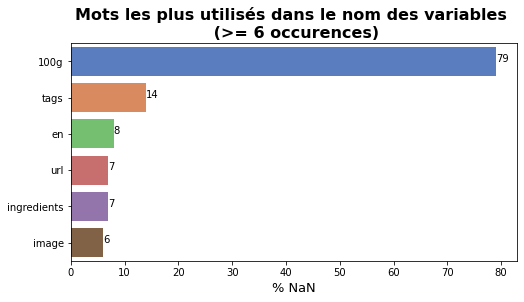

In [100]:
# Visualisation sous forme de barplot
plt.figure(figsize=(8, 4))
ax = sns.barplot(y = 'Mots', x = 'Nombre d\'occurences', data = most_common_columns_words, palette = 'muted')
plt.title("Mots les plus utilisés dans le nom des variables \n (>= 6 occurences)")
plt.ylabel("")
plt.xlabel("% NaN")
etiquette_h(ax);

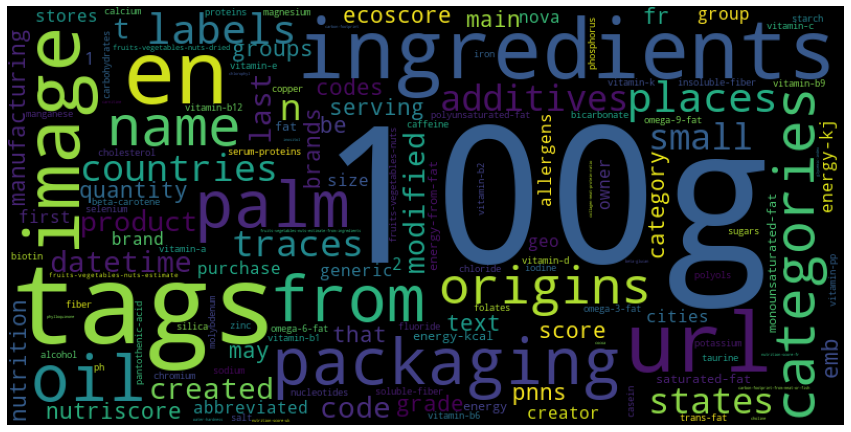

In [21]:
# Création d'un nuage de mots

# Conversion de la liste en dictionnaire valeurs / occurences
word_cloud_dict = Counter(liste_mots_colonnes_flat)
wordcloud = WordCloud(width = 800, height = 400).generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off");

### 100g <a class="anchor" id="100g"></a>

Les variables qui se terminent par _100g correspondent à la quantité de nutriments (en g ou kj pour l'énergie) pour 100g ou 100 ml de produit. Logiquement ces variables devraient être de type float.

In [22]:
# Liste des colonnes qui se terminent par _100g
print(openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_100g')].columns.tolist())

['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'starch_100g', 'polyols_100g', 'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', 'casein_100g', 'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'sele

In [23]:
# Dtypes des variables qui se terminent par _100g et qui ne sont pas de type float
openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_100g')].select_dtypes(exclude = ['float64']).dtypes

Series([], dtype: object)

Toutes ces variables sont bien au format float. En regardant la liste des colonnes, on peut se demander si les variables energy-kj_100g et energy_100g apportent la même information.

In [28]:
openfoodfacts[openfoodfacts[['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']].notnull().all(1)][
    ['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']].head()

,energy-kj_100g,energy-kcal_100g,energy_100g
4,685.8,163.9,685.8
417,2318.0,561.0,2318.0
419,1104.0,268.0,1104.0
790,442.0,1852.0,442.0
863,1926.0,460.0,1926.0


Les colonnes energy-kj_100g et energy_100g semblent être redondantes. Regardons la proportion de NaN.

In [29]:
print(f"% de NaN de la variable energy-kj_100g: {round(openfoodfacts['energy-kj_100g'].isna().mean(),4)*100}%")
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy-kj_100g: 92.7%
% de NaN de la variable energy_100g: 20.66%


La variables energy_100g comporte bien moins de valeurs manquantes que energy-kj_100g. Nous allons remplir les NaN de energy_100g avec les éventuelles  valeurs renseignées de energy-kj_100g puis supprimer la colonne energy-kj_100g.

In [31]:
# Pour les NaN de energy_100g, je complète avec energy-kj_100g sinon je laisse tel quel
openfoodfacts['energy_100g'] = np.where(openfoodfacts['energy_100g'].isnull(), 
                                        openfoodfacts['energy-kj_100g'], 
                                        openfoodfacts['energy_100g'])

In [32]:
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy_100g: 20.66%


La variable energy-kj_100g ne semble pas avoir diminué le taux de NaN de energy_100g, nous pouvons la supprimer.

In [33]:
openfoodfacts = openfoodfacts.drop('energy-kj_100g', 'columns')
openfoodfacts.shape

<ipython-input-33-112d0e192dab>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  openfoodfacts = openfoodfacts.drop('energy-kj_100g', 'columns')


(2053679, 147)

### tags <a class="anchor" id="tags"></a>

Les variables qui se terminent par _tags sont des variables qualitatives (packaging, marques, catégories etc). Elles doivent être de type "object".

In [35]:
openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_tags')].select_dtypes(exclude = ['object']).dtypes

Series([], dtype: object)

Toutes ces variables ont bien le dtype objet. A partir du préfixe des variables se terminant par _tags, tentons de récupérer les variables associées afin de s'assurer qu'elles ne sont pas redondantes. 

In [78]:
# Pour chaque colonne se terminant par _tags, je scinde son nom en plusieurs mots à partir du délimiteur _
# Je choisis l'indice [0] correspondant au premier élément 
liste_col_tags_prefixe = [i.replace('_tags', '') for i in openfoodfacts.iloc[
    :,openfoodfacts.columns.str.endswith('_tags')].columns.unique().tolist()]

print(f'Préfixes des colonnes se terminant par _tags: {liste_col_tags_prefixe}')

Préfixes des colonnes se terminant par _tags: ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places', 'labels', 'emb_codes', 'cities', 'countries', 'traces', 'additives', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'states']


In [79]:
# Selection des colonnes qui se terminent par _tags
liste_col_ends_tags = openfoodfacts.iloc[:,(openfoodfacts.columns.str.endswith(
    '_tags'))].columns.unique().tolist()

In [80]:
# Fusion des 2 listes + tri par ordre alphabétique
liste_col_tags = liste_col_tags_prefixe + liste_col_ends_tags
liste_col_tags.sort()

In [81]:
print(f'Colonnes + colonnes associées _tags:\n\n {liste_col_tags}')

Colonnes + colonnes associées _tags:

 ['additives', 'additives_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'cities', 'cities_tags', 'countries', 'countries_tags', 'emb_codes', 'emb_codes_tags', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'labels', 'labels_tags', 'manufacturing_places', 'manufacturing_places_tags', 'origins', 'origins_tags', 'packaging', 'packaging_tags', 'states', 'states_tags', 'traces', 'traces_tags']


Automatisation des étapes précédentes.

In [74]:
def liste_col_endswith(dataframe, keyword):
    ''' Fonction qui permet de récupérer le préfixe des colonnes se terminant par un mot clef et qui retourne une liste
    de ces variables et des variables associées qui contiennent le préfixe. L'objectif est de s'assurer que ces variables
    n'apportent pas la même information.'''
    
    liste_col_keyword_prefixe = [i.replace(f'_{keyword}', '') for i in dataframe.iloc[
    :,dataframe.columns.str.endswith(keyword)].columns.unique().tolist()]
    
    liste_col_ends_keyword = dataframe.iloc[:,(dataframe.columns.str.endswith(
    keyword))].columns.unique().tolist()
    
    liste_col_keyword = liste_col_keyword_prefixe + liste_col_ends_keyword
    liste_col_keyword.sort()
    
    return liste_col_keyword

In [75]:
liste_col_tags = liste_col_endswith(openfoodfacts, 'tags')

In [59]:
def describe_variables(data):
    ''' fonction qui prend un dataframe en entrée, et retourne un récapitulatif qui contient le nom des variables, 
    leur type, un exemple de modalité, le nombre total de lignes, le nombre et pourcentage de valeurs distinctes, 
    le nombre et pourcentage de valeurs non manquantes et de valeurs manquantes (NaN) et les principales statistiques 
    pour les variables numériques (moyenne, médiane, distribution, variance, écart type, minimum, quartiles et 
    maximum)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', '% distinct', 
                                 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 'Median', 'Skew', 'Kurtosis', 
                                 'Variance', 'Std', 'Min','25%','75%','Max'])
    
    # Pour chaque colonne du dataframe
    for column in data.columns:
        
        # Définition des variables
        var_type = data[column].dtypes # type de la variable (object, float, int...)
        example = data[data[column].notna()][column].iloc[0] # premier élément notNA
        #example = [data[data[column].notna()][column].iloc[0] if data[column].isna().sum() != len(data[column]) else 0]
        nb_raw = len(data[column]) # nombre total de lignes
        count = len(data[column])- data[column].isna().sum() # nombre de valeurs non manquantes
        percent_count = round(data[column].notnull().mean(),4)*100 # % de valeurs non manquantes
        distinct = data[column].nunique() # nombre de modalités que peut prendre la variable
        percent_distinct = round(data[column].nunique()/len(data[column]),4)*100 # % de valeurs distinctes
        missing = data[column].isna().sum() # nombre de valeurs manquantes
        percent_missing = round(data[column].isna().mean(),4)*100 # % de valeurs manquantes
        
        
        
        # Pour les variables de type 'int' ou 'float': on remplit toutes les colonnes
        if var_type == 'int' or var_type == 'float': 
            df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
                                          percent_count,missing, percent_missing,
                                          round(data[column].mean(),2),round(data[column].median(),2),
                                          round(data[column].skew(),2),round(data[column].kurtosis(),2),
                                          round(data[column].var(),2),round(data[column].std(),2),
                                          round(data[column].min(),2),round(data[column].quantile(0.25),2),
                                          round(data[column].quantile(0.75),2),data[column].max()]], 
                                        columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                                   '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 
                                                   'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min','25%',
                                                   '75%', 'Max']))
            
        
        
        # Pour les variables d'un autre type: on ne remplit que les variables de compte    
        else:            
            df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
                                          percent_count,missing, percent_missing,
                                          '','','','','','','','','','']], 
                                        columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                                   '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 
                                                   'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min', '25%', 
                                                   '75%', 'Max']))
            
    return df.reset_index(drop = True)

In [88]:
describe_variables(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_tags)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,packaging,object,"barquette,plastique",2053679,57066,2.78,315935,15.38,1737744,84.62,,,,,,,,,,
1,packaging_tags,object,"barquette,plastique",2053679,46485,2.26,315895,15.38,1737784,84.62,,,,,,,,,,
2,brands,object,endives,2053679,183520,8.94,1050597,51.16,1003082,48.84,,,,,,,,,,
3,brands_tags,object,endives,2053679,141427,6.89,1050528,51.15,1003151,48.85,,,,,,,,,,
4,categories,object,"Epicerie, Condiments, Sauces, Moutardes",2053679,117610,5.73,945149,46.02,1108530,53.98,,,,,,,,,,
5,categories_tags,object,"en:groceries,en:condiments,en:sauces,en:mustards",2053679,72803,3.55,945141,46.02,1108538,53.98,,,,,,,,,,
6,origins,object,Spain,2053679,14023,0.68,88290,4.30,1965389,95.70,,,,,,,,,,
7,origins_tags,object,en:spain,2053679,11428,0.56,88160,4.29,1965519,95.71,,,,,,,,,,
8,manufacturing_places,object,bénivay-ollon,2053679,28901,1.41,128424,6.25,1925255,93.75,,,,,,,,,,
9,manufacturing_places_tags,object,benivay-ollon,2053679,25973,1.26,128364,6.25,1925315,93.75,,,,,,,,,,


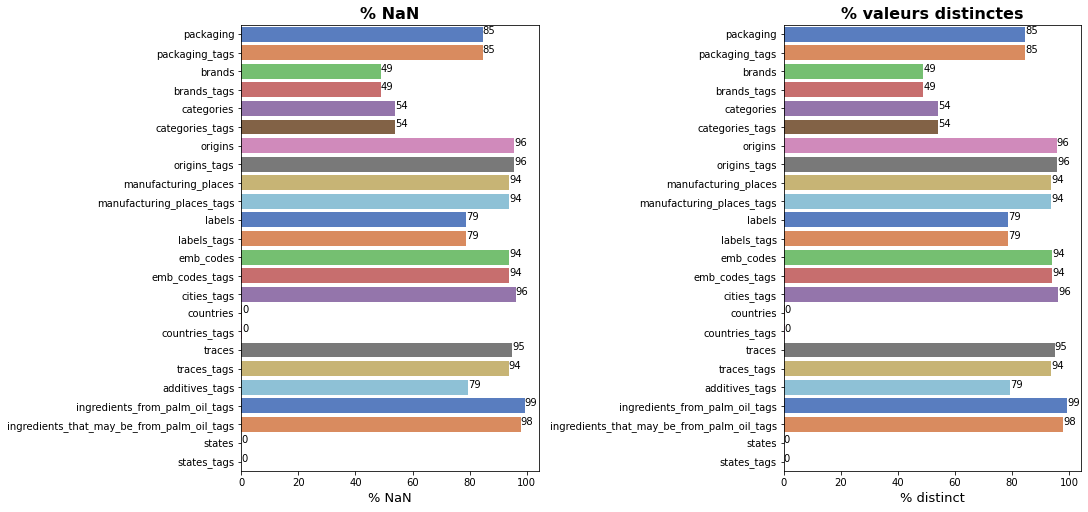

In [103]:
# Initialisation de la grille avec 1 ligne et 2 colonnes
fig = plt.figure(figsize=(15,7), constrained_layout=True)
gs = GridSpec(nrows=1, ncols=2, figure=fig)

# Premier graphique
ax1 = fig.add_subplot(gs[0,0]) # emplacement dans la grille
ax1 = sns.barplot(y = 'Variable name', x = '% NaN', data = describe_variables(openfoodfacts.iloc[
    :,openfoodfacts.columns.isin(liste_col_tags)]), palette = 'muted')
plt.title("% NaN")
plt.ylabel("")
plt.xlabel("% NaN")
etiquette_h(ax1)
        

# Deuxième graphique
ax1 = fig.add_subplot(gs[0,1]) # emplacement dans la grille
ax2 = sns.barplot(y = 'Variable name', x = '% NaN', data = describe_variables(openfoodfacts.iloc[
    :,openfoodfacts.columns.isin(liste_col_tags)]), palette = 'muted')
plt.title("% valeurs distinctes")
plt.ylabel("")
plt.xlabel("% distinct")
etiquette_h(ax2);

Nous remarquons que les variables se terminant par _tags comportent le même % de NaN que la variable associée mais le % de valeurs distinctes est quant à lui inférieur. Il semble être plus intéressant de conserver les variables se terminant par _tags et de supprimer les variables associées afin d'éviter la redondance d'information. De plus le site openfoodfacts nous indique que les variables _tags sont normalisées. Regardons quelques exemples avant de supprimer toutes les variables associées à celles se terminant par _tags.

In [ ]:
openfoodfacts[~openfoodfacts['labels'].isnull()][['labels', 'labels_tags']].sample(10)

In [ ]:
openfoodfacts[~openfoodfacts['categories'].isnull()][['categories', 'categories_tags']].sample(10)

Les variables semblent bien redondantes entre elles. Nous décidons de supprimer les variables sans le suffixe _tags.

In [ ]:
liste_col_suppr = openfoodfacts.iloc[:, (
    openfoodfacts.columns.str.startswith(tuple(liste_col_tags))
) & (~openfoodfacts.columns.str.endswith('_tags')) & (
    ~openfoodfacts.columns.str.endswith('_en')
) & (~openfoodfacts.columns.str.endswith('_n')) & (
    ~openfoodfacts.columns.str.endswith('_geo')
) & (~openfoodfacts.columns.str.endswith('_text')) & (
    ~openfoodfacts.columns.str.endswith('_url'))].columns.unique().tolist()

In [ ]:
print(f"Liste des variables à supprimer: \n\n {liste_col_suppr}")

In [ ]:
# Suppression des variables sans suffixe _tags
openfoodfacts_tags = openfoodfacts.drop(liste_col_suppr, axis = 'columns', inplace = False)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

### en <a class="anchor" id="en"></a>

La documentation nous indique que ces variables sont la traduction des variables _tags dans la langue indiquée.

In [ ]:
# Pour chaque colonne se terminant par _en, je scinde son nom en plusieurs mots à partir du délimiteur _
# Je choisis l'indice [0] correspondant au premier élément 
liste_col_en = [i.split('_')[0] for i in openfoodfacts_tags.iloc[
    :,openfoodfacts_tags.columns.str.endswith('_en')].columns.unique().tolist()]

print(f'Préfixes des colonnes se terminant par _en: {liste_col_en}')

In [ ]:
# Selection des colonnes qui commencent par un des mots de la liste liste_col_tags,
# ne se terminent par _en, _text , _n , _geo ou _url
liste_col_en = openfoodfacts_tags.iloc[:, (
    openfoodfacts_tags.columns.str.startswith(tuple(liste_col_en))
)].columns.unique().tolist()

print(f'Colonnes + colonnes associées _en:\n\n {liste_col_en}')

In [ ]:
describe_variables(openfoodfacts_tags[liste_col_en])

On remarque que les colonnes se terminant par _tags et _en sont redondantes entre elles. Le nombre de valeurs manquantes et de valeurs distinctes étant identique, on pourrait supprimer les colonnes _tags et ne garder que celles traduites en anglais pour avoir une base plus harmonisée. Vérifions d'abord sur quelques variables avant de les supprimer.

In [ ]:
openfoodfacts_tags[~openfoodfacts_tags['origins_tags'].isnull()][['origins_tags', 'origins_en']].sample(10)

In [ ]:
openfoodfacts_tags[~openfoodfacts_tags['traces_tags'].isnull()][['traces_tags', 'traces_en']].sample(10)

Les modalités étant plus lisibles et harmonisées dans les colonnes se terminant par _en, supprimons les colonnes _tags.

In [ ]:
liste_col_suppr = openfoodfacts_tags.iloc[:, (openfoodfacts_tags.columns.str.startswith(tuple(liste_col_en)))&
                       (openfoodfacts_tags.columns.str.endswith('_tags'))].columns.unique().tolist()

print(f'Colonnes _tags à supprimer:\n\n {liste_col_suppr}')

In [ ]:
# Suppression des variables avec suffixe _tags
openfoodfacts_tags.drop(liste_col_suppr, axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

### url <a class="anchor" id="url"></a>

Ces variables indiquent les urls des images et des produits et n'apportent aucune information. Supprimons les.

In [ ]:
liste_col_url = openfoodfacts_tags.iloc[:,
                                     openfoodfacts_tags.columns.str.contains(
                                         'url')].columns.unique().tolist()

print(f"Liste des variables url à supprimer: \n\n {liste_col_url}")

In [ ]:
# Suppression des variables contenant le mot url
openfoodfacts_tags.drop(liste_col_url, axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

### ingredients <a class="anchor" id="ingredients"></a>

In [ ]:
# Liste des variables contenant le mot ingredients
liste_col_ingredients = openfoodfacts_tags.iloc[:,
                                     openfoodfacts_tags.columns.str.contains(
                                         'ingredients')].columns.unique().tolist()

In [ ]:
# Exemples des variables contenant le mot ingredients sans NaN
openfoodfacts_tags[openfoodfacts_tags[liste_col_ingredients].notnull().all(1)][liste_col_ingredients].sample(5)

In [ ]:
describe_variables(openfoodfacts_tags[liste_col_ingredients])

Nous pouvons remarquer que la variable ingredients_text contient un grand nombre de modalités et 63.75% de valeurs manquantes. 

Nous pouvons également voir que 4 variables comportent la mention palm_oil dont 2 variables qui se terminent par _n indiquent le nombre d'ingrédients contenant de l'huile de palme. 

Les 2 variables ingredients_from_palm_oil_tags et ingredients_that_may_be_from_palm_oil_tags ont un pourcentage très élevé de valeurs manquantes et semblent redondantes avec les variables numériques, qui si supérieures à 0, indiquent la présence d'huile de palme ou assimilé. 

Nous allons supprimer ces 2 variables et ne conserver qu'une variable numérique sur les deux (ingredients_from_palm_oil_n).

In [ ]:
# Suppression des variables ingredients_from_palm_oil_tags et ingredients_that_may_be_from_palm_oil_tags
openfoodfacts_tags.drop(['ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags'],
                        axis = 'columns',
                        inplace = True)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

In [ ]:
# Suppression de la variable ingredients_that_may_be_from_palm_oil_n
openfoodfacts_tags.drop('ingredients_that_may_be_from_palm_oil_n',
                        axis = 'columns',
                        inplace = True)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

### image <a class="anchor" id="image"></a>

In [ ]:
liste_col_image = openfoodfacts_tags.iloc[:,
                                     openfoodfacts_tags.columns.str.contains(
                                         'image')].columns.unique().tolist()

liste_col_image

Les variables contenant le mot image ont été supprimées par les traitements précédents.

### packaging <a class="anchor" id="packaging"></a>

In [ ]:
# Variables contenant le mot packaging
liste_col_packaging = openfoodfacts_tags.iloc[:,
                                     openfoodfacts_tags.columns.str.contains(
                                         'packaging')].columns.unique().tolist()

liste_col_packaging

In [ ]:
# Description de ces variables
describe_variables(openfoodfacts_tags[liste_col_packaging])

In [ ]:
# Visualisation des modalités de ces 3 variables hors valeurs manquantes
openfoodfacts_tags[openfoodfacts_tags[liste_col_packaging].notnull().all(1)][liste_col_packaging].sample(5)

Les variables packaging_tags et packaging_text semblent être redondantes. La variable packaging_text contenant près de 99% de valeurs manquantes nous décidons de la supprimer.

La variable first_packaging_code_geo nous donne quant à elle des informations de geolocalisation (latitude / longitude). Nous pourrions créer deux nouvelles variables mais cette information ne nous semble par pertinente pour l'analyse. Nous la supprimons donc.

In [ ]:
# Suppression des variables packaging_text et first_packaging_code_geo
openfoodfacts_tags.drop(['packaging_text', 'first_packaging_code_geo'], axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

### name <a class="anchor" id="name"></a>

In [ ]:
# Variables contenant le mot name
liste_col_name = openfoodfacts_tags.iloc[:,
                                     openfoodfacts_tags.columns.str.contains(
                                         'name')].columns.unique().tolist()

liste_col_name

In [ ]:
# Description de ces variables
describe_variables(openfoodfacts_tags[liste_col_name])

In [ ]:
# Visualisation des modalités de ces 3 variables hors valeurs manquantes
openfoodfacts_tags[openfoodfacts_tags[liste_col_name].notnull().all(1)][liste_col_name].sample(5)

Ces trois variables nous apportent la même information. abbreviated_product_name et generic_name ayant un fort pourcentage de valeurs manquantes, nous décidons de supprimer ces 2 variables.

In [ ]:
# Suppression des variables abbreviated_product_name et generic_name
openfoodfacts_tags.drop(['abbreviated_product_name', 'generic_name'], axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

### places <a class="anchor" id="places"></a>

In [ ]:
# Variables contenant le mot places
liste_col_places = openfoodfacts_tags.iloc[:,
                                     openfoodfacts_tags.columns.str.contains(
                                         'places')].columns.unique().tolist()

liste_col_places

In [ ]:
# Description de ces variables
describe_variables(openfoodfacts_tags[liste_col_places])

In [ ]:
# Visualisation des modalités de ces 2 variables hors valeurs manquantes
openfoodfacts_tags[openfoodfacts_tags[liste_col_places].notnull().all(1)][liste_col_places].sample(5)

Ces variables étant très peu alimentées (plus de 90% de NaN), supprimons les.

In [ ]:
# Suppression des variables
openfoodfacts_tags.drop(liste_col_places, axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

### additives <a class="anchor" id="additives"></a>

In [ ]:
# Variables contenant le mot additives
liste_col_additives = openfoodfacts_tags.iloc[:,
                                     openfoodfacts_tags.columns.str.contains(
                                         'additives')].columns.unique().tolist()

liste_col_additives

In [ ]:
# Description de ces variables
describe_variables(openfoodfacts_tags[liste_col_additives])

Le pourcentage de valeurs manquantes étant "acceptable", nous décidons de conserver ces variables pour le moment.

### Autres variables  <a class="anchor" id="misc"></a>

La nomenclature des variables nous donne d'autres informations. Elle se trouve à l'adresse: https://static.openfoodfacts.org/data/data-fields.txt

#### Dates

In [ ]:
# Colonnes dont le titre se termine par "_t" ou "_datetime"
print("Liste des variables dont le titre se termine par _t ou _datetime: ")
liste_col_date = openfoodfacts_tags.iloc[:,(openfoodfacts_tags.columns.str.endswith('_datetime')) |
                   (openfoodfacts_tags.columns.str.endswith('_t'))].columns.tolist()
liste_col_date

In [ ]:
# Passage au bon format
from datetime import datetime
import time

for column in liste_col_date:
    if column.endswith('_t'):
        openfoodfacts_tags[column] = pd.to_datetime(openfoodfacts_tags[column], unit='s')
    else:
        openfoodfacts_tags[column] = pd.to_datetime(openfoodfacts_tags[column], format="%Y-%m-%d %H:%M:%S.%f", utc=True)

In [ ]:
openfoodfacts_tags[liste_col_date].head()

On remarque de la redondance d'information, on supprime les variables qui se terminent par _datetime puis nous créons des variables Année pour l'analyse future.

In [ ]:
# Suppression des variables redondantes
openfoodfacts_tags.drop(['created_datetime', 'last_modified_datetime'], axis=1, inplace = True)

In [ ]:
# On renomme les variables de date
openfoodfacts_tags.rename(columns={'created_t': 'creation_date', 
                              'last_modified_t': 'last_modified_date'}, inplace = True)

In [ ]:
# On créé des variables "Année"
openfoodfacts_tags['creation_year'] = pd.to_datetime(openfoodfacts_tags['creation_date'], format='%d:%m:%Y').dt.year
openfoodfacts_tags['last_modified_year'] = pd.to_datetime(openfoodfacts_tags['last_modified_date'], format='%d:%m:%Y').dt.year

In [ ]:
# On décale les colonnes "Année" après les colonnes de date:
colonne_a_decaler = openfoodfacts_tags.pop('creation_year') 
openfoodfacts_tags.insert(openfoodfacts_tags.columns.get_loc("creation_date")+1, 'creation_year', colonne_a_decaler) 

colonne_a_decaler = openfoodfacts_tags.pop('last_modified_year') 
openfoodfacts_tags.insert(openfoodfacts_tags.columns.get_loc("last_modified_date")+1, 'last_modified_year', colonne_a_decaler) 

In [ ]:
openfoodfacts_tags.dtypes[0:10]

#### serving_ 

Les variables qui commencent par _serving correspondent au nombre de nutriments (en g, ou kj pour l'énergie) pour une part du produit. Elles doivent être de type numérique.

In [ ]:
liste_col_serving = openfoodfacts_tags.iloc[:,
                                            openfoodfacts_tags.columns.str.
                                            startswith('serving_'
                                                       )].columns.unique(
                                                       ).tolist()

print(f"Liste des variables commençant par serving: \n\n {liste_col_serving}")

In [ ]:
# Exemples de variables contenant serving_ sans données manquantes
openfoodfacts_tags[openfoodfacts_tags[liste_col_serving].notnull().all(1)][liste_col_serving].sample(5)

Ces 2 colonnes semblent être redondantes, vérifions le % de NaN

In [ ]:
describe_variables(openfoodfacts_tags[liste_col_serving])

Le % de NaN étant assez similaire et la variable serving_quantity déjà au format numérique, supprimons la variable serving_size.

In [ ]:
# Suppression de la variable serving_size
openfoodfacts_tags.drop('serving_size', axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

<div class="alert alert-block alert-warning">
    <p> Suppression de variables pour libérer de la RAM </p>
</div>

In [ ]:
del(openfoodfacts)
del(colonne_a_decaler)
del(word_cloud_dict)
del(liste_mots_colonnes)
del(liste_mots_colonnes_flat)

## Doublons <a class="anchor" id="doublons"></a>

Il est important de vérifier que le dataset ne contienne pas de doublons. La variable "code" semble représenter la clé primaire de notre table. Vérifions dans un premier temps si cette variable contient plusieurs fois le même code. Ensuite nous vérifierons si un même produit existe plusieurs fois dans la base et adopterons une stratégie pour son traitement.  

### Variable Code <a class="anchor" id="doublons_code"></a>

In [ ]:
# Nombre de doublons sur la colonne code
print(f"Codes en doublons: {openfoodfacts.duplicated('code').sum()}")

In [ ]:
# Liste des codes dupliqués
liste_duplicated_codes = openfoodfacts_tags[openfoodfacts_tags['code'].duplicated()]['code'].tolist()

In [ ]:
# Affichage de toutes les lignes dupliquées du dataset
duplicated_code_raws = openfoodfacts_tags[openfoodfacts_tags['code'].isin(liste_duplicated_codes)]
duplicated_code_raws

In [ ]:
# Supprimons les lignes dupliquées qui ont le plus grand nombre de NaN par lignes
openfoodfacts_tags['null_count'] = openfoodfacts_tags.isnull().sum(1)

openfoodfacts_not_duplicated = openfoodfacts_tags.sort_values('null_count')\
       .drop_duplicates(subset = "code")\
       .sort_index()

In [ ]:
# Suppression de la variable null_count
openfoodfacts_not_duplicated.drop('null_count', axis='columns', inplace = True)

In [ ]:
print(f"Nombre de lignes: {openfoodfacts_not_duplicated.shape[0]}\nNombre de variables: {openfoodfacts_not_duplicated.shape[1]}")

In [ ]:
openfoodfacts_tags.shape[0] - openfoodfacts_not_duplicated.shape[0]

In [ ]:
del(openfoodfacts_tags)

### Variable Product Name <a class="anchor" id="doublons_product"></a>

Dans un premier temps, afin d'éviter d'avoir des produits différents à cause de la casse, modifions toutes les modalités des colonnes de type object en minuscules.

In [ ]:
liste_col_object = openfoodfacts_not_duplicated.select_dtypes(include=['object']).columns.tolist()

for col in liste_col_object:
    openfoodfacts_not_duplicated[col] = openfoodfacts_not_duplicated[col].str.lower()
    
openfoodfacts_not_duplicated.head(2)

In [ ]:
# Nombre de doublons sur la colonne product_name
n_duplicated_product = len(openfoodfacts_not_duplicated[
    'product_name']) -len(openfoodfacts_not_duplicated.drop_duplicates(
    subset = ['product_name']))

print(f'Produits en doublons: {n_duplicated_product}')

Plus de 857 000 produits ont le même nom dans le dataset. Regardons quelques lignes afin de mieux comprendre.

In [ ]:
# Liste des product_name dupliqués
liste_duplicated_products = openfoodfacts_not_duplicated[openfoodfacts_not_duplicated[
    'product_name'].duplicated()]['product_name'].tolist()

In [ ]:
# Affichage des lignes dupliquées du dataset
openfoodfacts_not_duplicated[openfoodfacts_not_duplicated['product_name'].isin(
    liste_duplicated_products)].sort_values(by = 'product_name', ascending=True)

In [ ]:
# Visualisation sous forme de countplot
plt.figure(figsize=(10,6))
ax = sns.countplot(y = 'product_name', data = openfoodfacts_not_duplicated,
                   order = openfoodfacts_not_duplicated['product_name'].value_counts().index[0:10],
                   palette = 'muted')
plt.title('TOP 10 des product_name les plus utilisées', fontweight='bold', fontsize = 15)
plt.xlabel("Nombre d'occurence", fontsize = 8)

total = len(openfoodfacts_not_duplicated['product_name'])
for p in ax.patches:
    etiquette ='{:,.0f}'.format(p.get_width())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(etiquette,(x,y))

Regardons plus en détail le product_name 'aceite de oliva virgen extra' et définissons une stratégie pour assainir la base.

In [ ]:
test_duplicated_huile_olive = openfoodfacts_not_duplicated[openfoodfacts_not_duplicated['product_name'] \
                                                           == 'aceite de oliva virgen extra']
test_duplicated_huile_olive.head()

In [ ]:
# Suppression des lignes avec 100% de données manquantes sur les colonnes de nutriments
liste_col_nutriments = openfoodfacts_not_duplicated.iloc[:,
                                                         openfoodfacts_not_duplicated.columns.str.endswith(
                                                             '_100g')].columns.tolist()

index_with_nan = test_duplicated_huile_olive.index[test_duplicated_huile_olive[liste_col_nutriments] \
                                                   .isnull().all(axis = 1)]

test_duplicated_huile_olive = test_duplicated_huile_olive.drop(index_with_nan,'index', inplace = False)
test_duplicated_huile_olive.head(5)

In [ ]:
# Apperçu des variables hors nutriments
test_duplicated_huile_olive.iloc[:, ~test_duplicated_huile_olive.columns.isin(liste_col_nutriments)]

La stratégie pourrait être par exemple de supprimer les lignes qui ont:
- le même nom de produit et de marque hors NaN
- le plus grand nombre de NaN par ligne

In [ ]:
# Nombre de doublons sur la colonne product_name et brands_tags (hors NaN)
n_duplicated_product_brand = len(test_duplicated_huile_olive[['product_name', 
                                                              'brands_tags']])-len(
    test_duplicated_huile_olive.drop_duplicates(subset = ['product_name', 
                                                          'brands_tags']))

print(f'Nombre de produits avec la même marque (hors NaN): {n_duplicated_product_brand}')

In [ ]:
# Mask de dataframe avec product et brands non nuls
test_duplicated_huile_olive = test_duplicated_huile_olive[test_duplicated_huile_olive[['product_name', 
                                                                     'brands_tags']].notnull().all(1)]

# Création colonne qui compte le nombre de NaN par ligne
#test_duplicated_huile_olive['NaN_count'] = test_duplicated_huile_olive.isnull().sum(1)
test_duplicated_huile_olive.loc[:, 'NaN_count'] = test_duplicated_huile_olive.isnull().sum(1)


# Suppression des lignes dupliquées quand le produit et la marque sont renseignés en fonction du 
# nombre de NaN par ligne
test_duplicated_huile_olive = test_duplicated_huile_olive[
    test_duplicated_huile_olive[['product_name', 
                                 'brands_tags']].notnull().all(1)].sort_values(
    'NaN_count').drop_duplicates(subset = ['product_name', 'brands_tags']).sort_index()

# Suppression variable NaN_count
test_duplicated_huile_olive.drop('NaN_count', axis='columns', inplace = True)

In [ ]:
# On ajoute la liste des index retraités et ceux où le produit ou la marque sont nuls
index_not_duplicated = test_duplicated_huile_olive.index
index_NaN = test_duplicated_huile_olive[test_duplicated_huile_olive[['product_name', 
                                                                     'brands_tags']].isnull().any(1)].index

index_to_keep = index_not_duplicated.union(index_NaN)

In [ ]:
test_duplicated_huile_olive = test_duplicated_huile_olive.loc[index_not_duplicated, :]
test_duplicated_huile_olive.head(5)

In [ ]:
test_duplicated_huile_olive['product_name'].groupby(test_duplicated_huile_olive[
    'brands_tags']).count().reset_index(name = 'Count').sort_values(
    by = 'Count', ascending = False)

On obtient bien un produit par marque. Appliquons cette stratégie aux autres produits.

In [ ]:
def del_duplicated(df):
    ''' fonction qui prend un dataframe en entrée, supprime les lignes dupliquées sur le product_name et
    les brands_tags en gardant celles qui ont le moins de données manquantes par ligne'''
        
    # Suppression des lignes avec 100% de données manquantes sur les colonnes de nutriments
    liste_col_nutriments = df.iloc[:,df.columns.str.endswith('_100g')].columns.tolist()
        
    index_with_nan = df.index[df[liste_col_nutriments].isnull().all(axis = 1)]
        
    df = df.drop(index_with_nan,'index', inplace = False)

    
    # Sélection des variables hors NaN
    df_hors_NaN = df[df[['product_name', 'brands_tags']].notnull().all(1)]
    
    # Création colonne qui compte le nombre de NaN par ligne
    #df_hors_NaN['NaN_count'] = df_hors_NaN.isnull().sum(1)
    df_hors_NaN.loc[:, 'NaN_count'] = df_hors_NaN.isnull().sum(1)
    
    # Suppression des lignes dupliquées quand le produit et la marque sont renseignés en fonction du 
    # nombre de NaN par ligne
    df_hors_NaN = df_hors_NaN[df_hors_NaN[['product_name', 'brands_tags']].notnull().all(1)].sort_values(
        'NaN_count').drop_duplicates(subset = ['product_name', 'brands_tags']).sort_index()
            
    # Suppression variable NaN_count
    df_hors_NaN.drop('NaN_count', axis='columns', inplace = True)
    
    # On ajoute la liste des index retraités et ceux où le produit ou la marque sont nuls
    index_not_duplicated = df_hors_NaN.index
    index_NaN = df[df[['product_name', 'brands_tags']].isnull().any(1)].index
    index_to_keep = index_not_duplicated.union(index_NaN)
    
    df = df.loc[index_to_keep, :]
    
    return df

In [ ]:
# Nombre de doublons sur la colonne product_name et brands_tags (hors NaN)
n_duplicated_product_brand = len(openfoodfacts_not_duplicated[['product_name', 
                                                              'brands_tags']])-len(
    openfoodfacts_not_duplicated.drop_duplicates(subset = ['product_name', 
                                                          'brands_tags']))

print(f'Nombre de produits avec la même marque (hors NaN): {n_duplicated_product_brand}')

In [ ]:
openfoodfacts_not_duplicated = del_duplicated(openfoodfacts_not_duplicated)

In [ ]:
brands_per_product = pd.DataFrame(data = openfoodfacts_not_duplicated[['product_name', 
                              'brands_tags']].groupby(['product_name', 'brands_tags'])['brands_tags'].count())

brands_per_product.rename(columns={'brands_tags': 'Nombre de marques par produit'}, inplace=True)
brands_per_product = brands_per_product.sort_values(by='Nombre de marques par produit', ascending=False)

brands_per_product

Les doublons marque / produits ont bien été supprimés.

In [ ]:
print(f"Nombre de lignes: {openfoodfacts_not_duplicated.shape[0]}\nNombre de variables: {openfoodfacts_not_duplicated.shape[1]}")

In [ ]:
# Nombre de NaN sur les produits ou la marque
len(openfoodfacts_not_duplicated[openfoodfacts_not_duplicated[['product_name', 'brands_tags']].isnull().any(1)].index)

In [ ]:
len(openfoodfacts_not_duplicated[~openfoodfacts_not_duplicated[['product_name', 'brands_tags']].isnull().any(1)].index)

In [ ]:
750743+778587

In [ ]:
1996414-1529330

In [ ]:
1996414-273827

<div class="alert alert-block alert-info">
    <p> Vérifier si la suppression des doublons est cohérente: cf nb </p>
</div>

## Sélection de variables pertinentes <a class="anchor" id="selec_var"></a>

Regardons tout d'abord le taux de remplissage de chaque variable et tentons de sélectionner un seuil de taux de remplissage minimum ou de définir quelles variables ne doivent pas contenir de valeurs manquantes.

In [ ]:
plt.figure(figsize = (20, 40))

ax = sns.barplot(y = 'Variable name', x='% Not NaN', data = describe_variables(openfoodfacts_tags).sort_values(
    by = '% Not NaN', ascending = False))
plt.title('Taux de remplissage des variables', fontweight = 'bold', fontsize = 15)
plt.ylabel("", fontsize = 12)
plt.xlabel("Taux de remplissage", fontsize = 12)

for item in ax.get_xticklabels(): # rotation axe des abscisses
    item.set_rotation(0)

total = len(describe_variables(openfoodfacts_tags)['Variable name'])
for p in ax.patches:
    etiquette ='{:,.0f}'.format(p.get_width())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(etiquette,(x,y))

plt.show()

In [ ]:
# % NaN du dataset et % de données remplies
print('Taux de NaN du dataset:')
print(round((openfoodfacts_tags.isna().sum().sum()) / 
            (openfoodfacts_tags.shape[0]*openfoodfacts_tags.shape[1])*100,2))

print('Taux de remplissage du dataset')
print(round(100 - (openfoodfacts_tags.isna().sum().sum()) / 
                  (openfoodfacts_tags.shape[0]*openfoodfacts_tags.shape[1])*100),2)

In [ ]:
# Fonction permettant de supprimer les variables en fonction d'un taux de remplissage par colonne

def suppress_nan(dataframe, tx_remplissage_col = 50) :
    '''Suppression des variables dont le taux de remplissage est inférieur au taux de remplissage
    demandé (50% par défaut)'''
    
    liste_col_pallier_NaN = [c for c in dataframe.columns if 
                             (dataframe[c].notnull().sum().sum()/
                              (dataframe[c].size)) * 100 >= tx_remplissage_col]
    
    dataframe = dataframe.iloc[:,dataframe.columns.isin(liste_col_pallier_NaN)]
    return dataframe

In [ ]:
suppress_nan(openfoodfacts_tags, tx_remplissage_col = 10)

In [ ]:
describe_variables(openfoodfacts_tags).sort_values(by = '% Not NaN', ascending = False)

Certaines variables sont nécessaires dans notre analyse future et ne doivent pas contenir de valeurs manquantes. C'est le cas par exemple du product_name et des variables contenant le mot "nutriscore".

**Product_name**

In [ ]:
# Exemples de la variable product_name NaN 
openfoodfacts_tags[openfoodfacts_tags['product_name'].isnull()].sample(5)

In [ ]:
index_with_nan = openfoodfacts_tags.index[openfoodfacts_tags['product_name'].isnull()]
index_with_nan.shape

In [ ]:
openfoodfacts_not_NaN = openfoodfacts_tags.drop(index_with_nan,'index', inplace = False)
openfoodfacts_not_NaN.shape

In [ ]:
# Vérification que le bon nombre de ligne a été supprimé
(openfoodfacts_tags.shape[0] - openfoodfacts_not_NaN.shape[0]) == index_with_nan.shape[0]

In [ ]:
# % NaN du dataset
print('Taux de NaN du dataset:')
print(round((openfoodfacts_not_NaN.isna().sum().sum()) / 
            (openfoodfacts_not_NaN.shape[0]*openfoodfacts_not_NaN.shape[1])*100,2))

In [ ]:
# % de NaN en fonction d'un pallier de suppression des NaN

**Variable nutriscore_score**

In [ ]:
# Exemples de la variable nutriscore_score NaN 
openfoodfacts_not_NaN[openfoodfacts_not_NaN[['nutriscore_score', 'nutriscore_grade']].isnull().all(1)].sample(5)

In [ ]:
index_with_nan = openfoodfacts_not_NaN.index[openfoodfacts_not_NaN[['nutriscore_score', 
                                                                    'nutriscore_grade']].isnull().all(1)]
index_with_nan.shape

In [ ]:
openfoodfacts_not_NaN.drop(index_with_nan,'index', inplace = True)
openfoodfacts_not_NaN.shape

<div class="alert alert-block alert-info">
    <p> Variables qui doivent être remplies comme product name </p>
</div>

## Gestion des valeurs manquantes <a class="anchor" id="nan"></a>

In [ ]:
sns.set(style="whitegrid")
ax = sns.distplot(proportion_nan.values)
ax.xaxis.set_ticks_position('top')
plt.title('Répartition de la quantité de NaN', size=15)
plt.show()

Dans cette partie nous allons tout d'abord vérifier:
- si le type des variables est cohérent
- si des variables sont redondantes
- si des observations sont dupliquées
- analyser les données manquantes et définir une stratégie pour les traiter
- gérer les outliers

<div class="alert alert-block alert-info">
    <p> Check dtypes </p>
</div>

### Type des variables <a class="anchor" id="typevar"></a>

#### Autres variables <a class="anchor" id="misc"></a>

Filtre contient pas 100g, _tags et serving_

In [ ]:
describe_variables(openfoodfacts_tags.iloc[:,(~openfoodfacts_tags.columns.str.endswith('_date'))&
                        (~openfoodfacts_tags.columns.str.endswith('_year'))&
                        (~openfoodfacts_tags.columns.str.endswith('_100g'))&
                        (~openfoodfacts_tags.columns.str.startswith('serving_'))
                       ])
#.columns.unique().tolist()

In [ ]:
# Fonction qui supprime les colonnes d'un dataframe en fonction d'un seuil de NaN
def suppr_NaN_colonne(data, tx_NaN = 100):
    """
    Fonction qui supprime les colonnes d'un dataframe en fonction d'un pourcentage de valeurs manquantes
    
    Args:
        data: dataset en entrée
        tx_NaN: pourcentage de valeurs manquante
        
    Returns:
        Dataset au format dataframe imputé des colonnes composées de x % de valeurs manquantes
    """
    column_with_nan = data.columns[data.isnull().any()]
    
    for column in column_with_nan:
        if (data[column].isnull().sum()/data.shape[0])*100 >= tx_NaN:
            data.drop(column,1, inplace=True)
            return(data)

[Retour à la table des matières](#0)